In [1]:
import sys
sys.path.append('../')
from msBO import MultiStateBO
from msBO.objective import BPMvar_minimization
sys.path.append('../../machineIO/')
from machineIO import construct_machineIO, StatefulOracleEvaluator
from machineIO.preset import get_limits

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from epics import caget, caget_many, caput_many
from phantasy import fetch_data
import datetime
from phantasy import ensure_set, fetch_data

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

In [23]:
n_init = 8
n_each = 2
n_states = 3
n_iter = 3

In [3]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 28Si9 A/Q= 3.111111111111111


In [4]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][msBO]test'
fname

'20251124_2027[28Si9][msBO]test'

### construct machineIO

In [5]:
mIO = construct_machineIO(ensure_set_timeout = 30, 
                          ensure_set_timewait_after_ramp = 0.3,
                          fetch_data_time_span = 2.0)

In [6]:
mIO.__dict__

{'_ensure_set_timeout': 30,
 '_ensure_set_timewait_after_ramp': 0.3,
 '_fetch_data_time_span': 2.0,
 '_sample_interval': 0.2,
 '_verbose': False,
 '_n_popup_ramping_issue': 0,
 '_history_lock': <unlocked _thread.lock object at 0x7f16d7754f40>,
 'history': [],
 'test': False,
 'isOK_PVs': ['ACS_DIAG:CHP:STATE_RD'],
 'isOK_vals': [3],
 '_ensure_set': <machineIO.construct_machineIO._ensure_set_wrapper at 0x7f16d05fa450>,
 '_fetch_data': <machineIO.construct_machineIO._fetch_data_wrapper at 0x7f16d03fd850>}

In [26]:
ramping_time = 1
BO_comp_time = 10
dt = mIO._ensure_set_timewait_after_ramp + mIO._fetch_data_time_span + ramping_time + BO_comp_time
print(f'expected run time: {int((n_init*n_state + n_iter*n_states*n_each)*dt/60)} min')

expected time: 1 min


### control knobs

In [7]:
control_CSETs = [
    'LS3_CD06:PSC2_D4669:I_CSET',
    'LS3_CD06:PSC1_D4669:I_CSET',
    'LS3_BTS:PSC2_D4709:I_CSET',
    'LS3_BTS:PSC1_D4709:I_CSET',
    
]
control_RDs = [pv.replace('CSET','RD') for pv in control_CSETs]
control_ref = caget_many(control_CSETs)

control_tols = []
control_min = []
control_max = []
for v, PV in zip(control_ref,control_CSETs):
    if ':PSC' in PV:
        control_min.append(v - 0.3)
        control_max.append(v + 0.3)
        control_tols.append(0.1)
#     elif ':PSQ_' in PV:
#         control_min.append(v*0.95)
#         control_max.append(v*1.05)
#         control_tols.append(0.1)
#     elif ':PSS_' in PV:
#         control_min.append(v*0.2)
#         control_max.append(v*1.8)
#         control_tols.append(0.05)
    else:
        raise ValueError(f'control min/max cannot be determined automatically for {PV}')
control_min[-1] -= 1.2
control_max[-1] += 1.2
        
##== Manually set decision bounds and tolerance
# control_min = [ -5, -5, -5, -5]
# control_max = [  5,  5,  5,  5]
# control_tols = [0.2,0.2,0.2,0.2]

assert len(control_CSETs) == len(control_min) == len(control_max) == len(control_tols)
control_Lo_limit, control_Hi_limit = get_limits(control_CSETs)
control_min = np.clip(control_min, a_min = control_Lo_limit, a_max = None)
control_max = np.clip(control_max, a_min = None, a_max = control_Hi_limit)
assert np.all(control_max > control_min)

pd.DataFrame(np.array([control_ref,control_min,control_max,control_tols,control_Lo_limit,control_Hi_limit]).T,
             index=control_CSETs, 
             columns=['current value','decision min','decision max','tol','LoLim','HiLim'])

,current value,decision min,decision max,tol,LoLim,HiLim
LS3_CD06:PSC2_D4669:I_CSET,0.7876,0.4876,1.0876,0.1,-5.0,5.0
LS3_CD06:PSC1_D4669:I_CSET,0.7360,0.4360,1.0360,0.1,-5.0,5.0
LS3_BTS:PSC2_D4709:I_CSET,-10.0790,-10.3790,-9.7790,0.1,-39.0,39.0
LS3_BTS:PSC1_D4709:I_CSET,-1.8850,-3.3850,-0.3850,0.1,-19.0,19.0


In [8]:
# control_couplings = {
#     'FS1_BBS:PSQ_D2416:I_CSET':
#         {
#             'CSETs' :['FS1_BBS:PSQ_D2424:I_CSET','FS1_BBS:PSQ_D2463:I_CSET','FS1_BBS:PSQ_D2472:I_CSET'],
#             'RDs'   :[],
#             'tols'  :[],
#             'coeffs':[],
#         },
#      'FS1_BBS:PSS_D2419:I_CSET':
#         {
#             'CSETs' :['FS1_BBS:PSS_D2469:I_CSET'],
#             'RDs'   :[],
#             'tols'  :[],
#             'coeffs':[],
#         },
# }

# for pv, val in control_couplings.items():
#     x = caget(pv)
#     y = np.array(caget_many(val['CSETs']))
#     ipv = control_CSETs.index(pv)
#     tol = control_tols[ipv]
#     val['RDs'] = [pv.replace('CSET','RD') for pv in val['CSETs']]
#     val['tols'] = [tol]*len(val['CSETs'])
#     val['coeffs'] = y/x
    
# control_couplings

### state definition

In [9]:
state_CSETs  = ['LS3_BTS:PSQ_D4713:I_CSET','LS3_BTS:PSQ_D4718:I_CSET']
state_RDs    = [pv.replace('I_CSET','I_RD') for pv in state_CSETs]
state_tols   = [0.2]*len(state_CSETs)
state_val0   = caget_many(state_CSETs)
state_key_vals  = {'-20%':[v*0.8 for v in state_val0],
                   '+20%':[v*1.2 for v in state_val0],
                   '-/+10%':[state_val0[0]*0.9, state_val0[1]*1.1]}
states = list(state_key_vals.keys())
n_states = len(states)
state_key_vals

{'-20%': [15.4696, 28.5424],
 '+20%': [23.2044, 42.813599999999994],
 '-/+10%': [17.4033, 39.2458]}

### monitors

In [10]:
monitor_BPMs = ['LS3_BTS:BPM_D4753','LS3_BTS:BPM_D4769']
monitor_RDs = []
for bpm in monitor_BPMs:
    monitor_RDs += [bpm+':XPOS_RD',bpm+':YPOS_RD',bpm+':MAG_RD']
#     monitor_RDs += [bpm+':YPOS_RD',bpm+':MAG_RD']

### Define Oracle 
# WARN!  This cell may change state!

In [11]:
bpm_posRDs = [pv for pv in monitor_RDs if 'POS_RD' in pv]
bpm_magRDs = [pv for pv in monitor_RDs if 'MAG_RD' in pv]

BPM_MAGs_ref = {}
for state, goal in state_key_vals.items():
    ret = ensure_set(state_CSETs,state_RDs,goal,state_tols,timeout=30)
#     input(f"{state_CSETs},{goal}")
    val, _ = fetch_data(bpm_magRDs,5)
    BPM_MAGs_ref[state] = val

[20:27:23.503] WARNING: phantasy.~.epics_tools: Established 2 PVs in 25.2 ms.
[20:27:59.281] WARNING: phantasy.~.epics_tools: Established 2 PVs in 0.0 ms.
[20:28:05.467] WARNING: phantasy.~.epics_tools: Established 2 PVs in 0.0 ms.


In [12]:
def BPM_MAG_obj(df,s):
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    return df

In [13]:
oracle_key_names = {'x':control_RDs,
                    'y':bpm_posRDs + ['BPM:MAG_min_ratio']}
oracle_key_names

{'x': ['LS3_CD06:PSC2_D4669:I_RD',
  'LS3_CD06:PSC1_D4669:I_RD',
  'LS3_BTS:PSC2_D4709:I_RD',
  'LS3_BTS:PSC1_D4709:I_RD'],
 'y': ['LS3_BTS:BPM_D4753:XPOS_RD',
  'LS3_BTS:BPM_D4753:YPOS_RD',
  'LS3_BTS:BPM_D4769:XPOS_RD',
  'LS3_BTS:BPM_D4769:YPOS_RD',
  'BPM:MAG_min_ratio']}

In [14]:
oracleEvaluator = StatefulOracleEvaluator(
    mIO,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = monitor_RDs,
#     control_couplings = control_couplings,
    state_df_manipulators = [BPM_MAG_obj],
)

# Define Composite Object

In [15]:
n_state = len(states)
n_task = len(bpm_posRDs)+1
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

# Define msBO

In [16]:
local_optimization = False
acq_type = 'EI'
fix_acq_state = False

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

[20:28:10.614] WARNING: phantasy.~.epics_tools: Established 19 PVs in 123.4 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


# run msBO

In [17]:
msbo.init(n_init=n_init, local_optimization=local_optimization)
for i_iter in range(n_iter):
    if i_iter%2==0:
        states_order = states[::-1]
    else:
        states_order = states
    for s in states_order:
        print(i_iter, s)
        for i_each in range(n_each):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state)

[20:28:14.686] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:19.352] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:25.152] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:29.556] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:34.960] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:39.371] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:43.763] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:28:49.775] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:29:22.613] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:29:55.393] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:30:28.116] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:31:00.800] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:31:33.600] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:32:06.590] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:32:39.408] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:12.200] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:17.154] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:21.757] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:27.560] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:31.954] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:37.355] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:41.771] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:46.161] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:33:52.161] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):
/user/shared/ap-ml/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


[20:34:24.151] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:34:46.907] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:36:00.523] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:37:09.585] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:37:58.991] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:38:57.383] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[20:39:50.804] WARNING: phantasy.~.epics_tools: Established 19 PVs in 0.1 ms.


KeyboardInterrupt: 

### visualize optimization result

(0.97, 1.0)

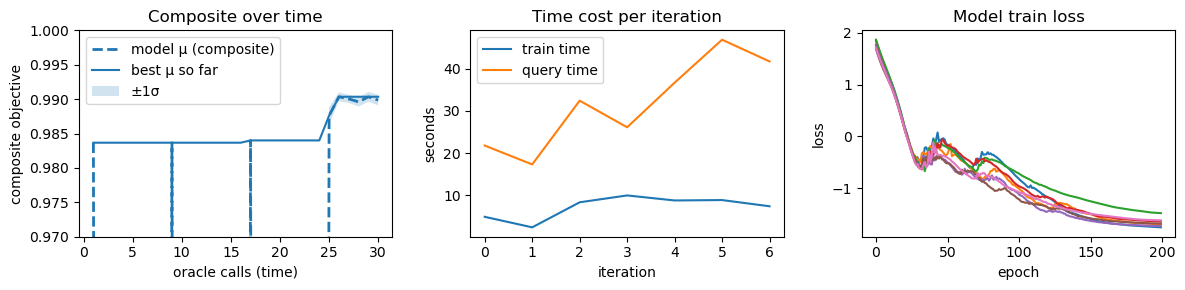

In [22]:
fig,ax, virtualObjMean = msbo.plot_composite_objective()
ax[0].set_ylim(0.97,1)

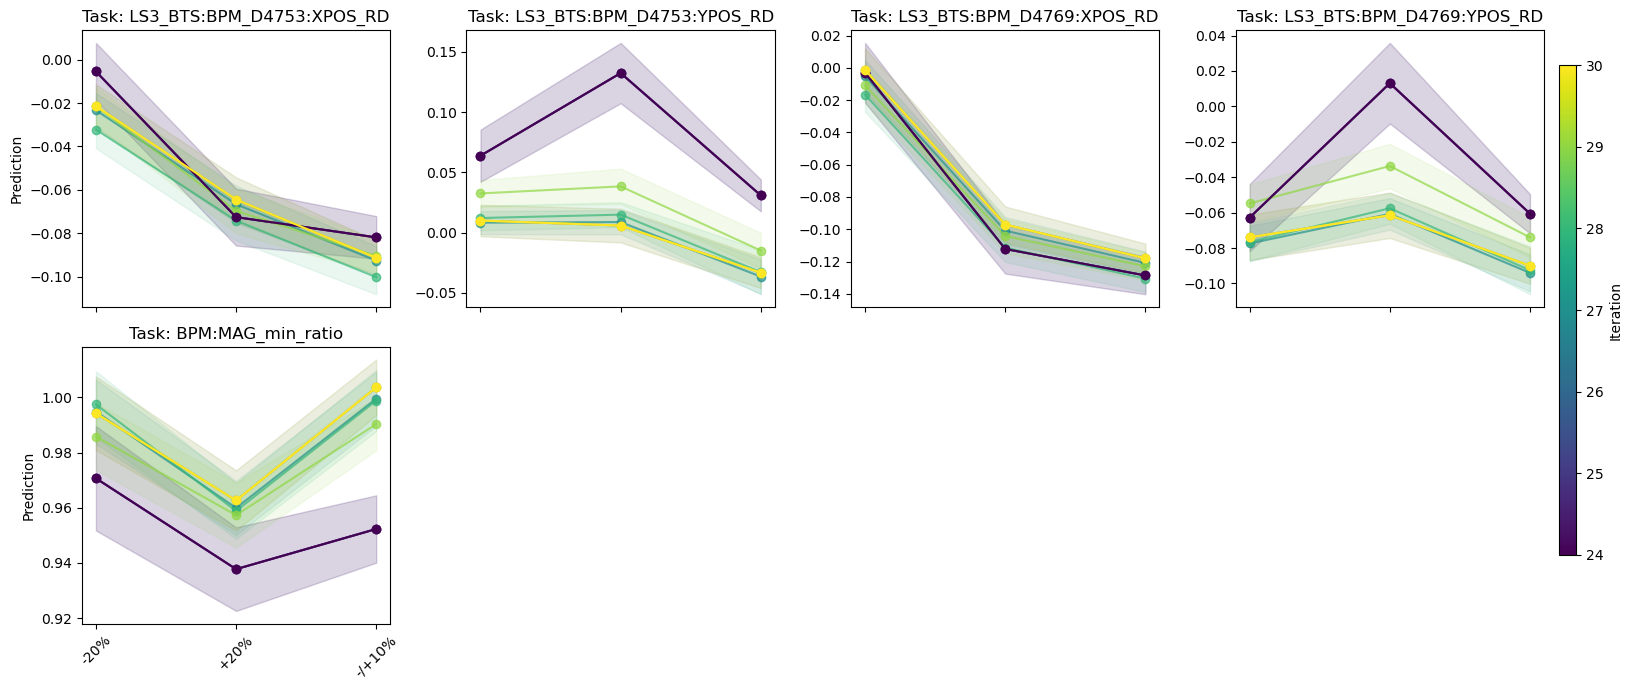

In [19]:
fig, axes = msbo.plot_state_predictions_history()

### set to best solution

In [31]:
x_best = msbo.history['predictions'][-1]['x_best']
caput_many(control_CSETs,x_best)

### restore states

In [20]:
caput_many(state_CSETs,state_val0)

[1, 1]

### restore control if optimization result is not good

In [ ]:
# caput_many(control_CSETs,control_ref)